In [ ]:
# Install Required Libraries
!pip install transformers datasets evaluate matplotlib scikit-learn seaborn pandas --quiet

# Import Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import load_dataset
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import random

In [ ]:
# 1. Introduction
"""
In this project, we aim to improve trust in AI-based sentiment analysis models
by applying a lightweight modification: a confidence threshold.
This addresses the risk of low-confidence predictions misleading users.
"""

# ✨ 2. Load Model and Tokenizer
model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# 3. Load Dataset and Show Some Samples
dataset = load_dataset("tweet_eval", "sentiment")

# Convert dataset to DataFrame for easier viewing
test_dataset = dataset['test'].to_pandas()

# Show the structure of the dataset
print("Sample tweets from dataset:")
display(test_dataset.head())

Sample tweets from dataset:


,text,label
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0


In [ ]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12284 entries, 0 to 12283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12284 non-null  object
 1   label   12284 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.1+ KB


In [ ]:
test_dataset['label'].value_counts()

,count
label,
1,5937
0,3972
2,2375


In [ ]:
# 3.1 Create Human-Readable Sentiment Column
label_mapping = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

# Map numeric labels to text labels
test_dataset['sentiment_text'] = test_dataset['label'].map(label_mapping)

# Display few rows again
print("Sample tweets from dataset (with Sentiment Names):")
display(test_dataset.head())

Sample tweets from dataset (with Sentiment Names):


,text,label,sentiment_text
0,@user @user what do these '1/2 naked pics' hav...,1,Neutral
1,OH: “I had a blue penis while I was this” [pla...,1,Neutral
2,"@user @user That's coming, but I think the vic...",1,Neutral
3,I think I may be finally in with the in crowd ...,2,Positive
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0,Negative


In [ ]:
# 4. Set Up Sentiment Pipeline
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

# 5. Sampling 10,000 Tweets
sample_texts = test_dataset['text'][:10000]
sample_labels = test_dataset['label'][:10000]

print(f"Loaded {len(sample_texts)} tweets for evaluation.")

# 6. Define Trust Problem
"""
Problem:
Low-confidence sentiment predictions can mislead users and reduce trust in AI systems.
We need a mechanism to improve trustworthiness by filtering unreliable outputs.
"""

Device set to use cuda:0


Loaded 10000 tweets for evaluation.


'\nProblem:\nLow-confidence sentiment predictions can mislead users and reduce trust in AI systems.\nWe need a mechanism to improve trustworthiness by filtering unreliable outputs.\n'

Original Trust Metric (Accuracy): 72.38%


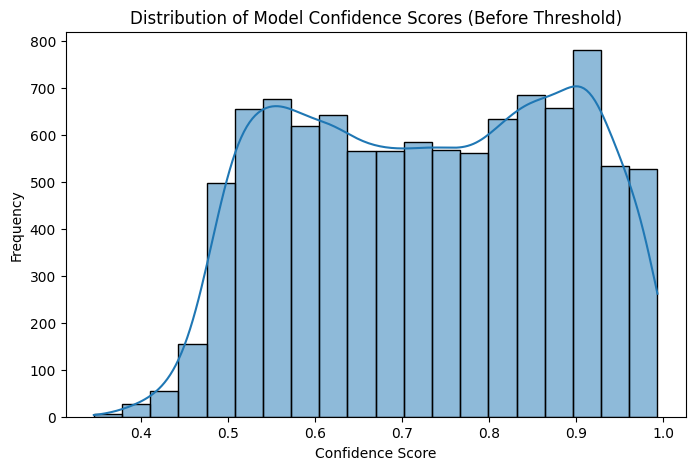

In [ ]:
# 7. Trustworthiness Metric: Accuracy Before Modification
predictions = sentiment_pipeline(sample_texts.tolist())
predicted_labels = [0 if pred['label'] == 'LABEL_0' else (1 if pred['label'] == 'LABEL_1' else 2) for pred in predictions]

correct = sum([pred == true for pred, true in zip(predicted_labels, sample_labels)])
initial_accuracy = correct / len(sample_labels)

print(f"Original Trust Metric (Accuracy): {initial_accuracy*100:.2f}%")

# 8. Visualize Confidence Score Distribution
confidence_scores = [pred['score'] for pred in predictions]

plt.figure(figsize=(8,5))
sns.histplot(confidence_scores, bins=20, kde=True)
plt.title("Distribution of Model Confidence Scores (Before Threshold)")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# 9. Apply Confidence Threshold
CONFIDENCE_THRESHOLD = 0.7

def predict_with_confidence(tweet_text):
    prediction = sentiment_pipeline(tweet_text)
    score = prediction[0]['score']
    label = prediction[0]['label']

    if score < CONFIDENCE_THRESHOLD:
        return "UNTRUSTWORTHY", score
    else:
        return label, score

filtered_predictions = []
filtered_labels = []

for text, true_label in zip(sample_texts.tolist(), sample_labels.tolist()):
    pred_label, score = predict_with_confidence(text)
    if pred_label != "UNTRUSTWORTHY":
        filtered_predictions.append(0 if pred_label == 'LABEL_0' else (1 if pred_label == 'LABEL_1' else 2))
        filtered_labels.append(true_label)

Trust Metric After Applying Confidence Threshold: 82.21%


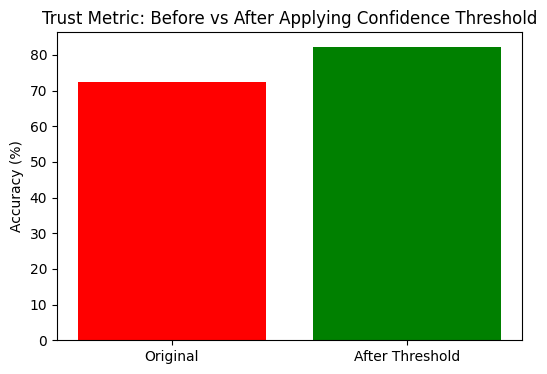

In [ ]:
# 10. Evaluate Trust Metric After Modification
if filtered_predictions:
    correct_filtered = sum([pred == true for pred, true in zip(filtered_predictions, filtered_labels)])
    new_accuracy = correct_filtered / len(filtered_predictions)
    print(f"Trust Metric After Applying Confidence Threshold: {new_accuracy*100:.2f}%")
else:
    new_accuracy = 0
    print("All predictions filtered out. No trustworthy predictions made.")


# 11. Plot Accuracy Before vs After
plt.figure(figsize=(6,4))
plt.bar(["Original", "After Threshold"], [initial_accuracy*100, new_accuracy*100], color=["red", "green"])
plt.ylabel("Accuracy (%)")
plt.title("Trust Metric: Before vs After Applying Confidence Threshold")
plt.show()

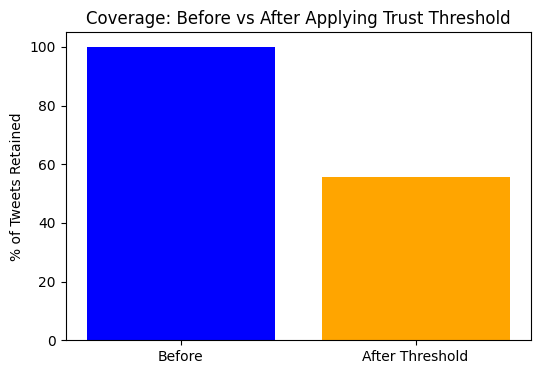

Coverage After Applying Confidence Threshold: 55.70%


In [ ]:
# 12. Coverage Analysis
coverage = len(filtered_labels) / len(sample_labels)

plt.figure(figsize=(6,4))
plt.bar(["Before", "After Threshold"], [100, coverage*100], color=["blue", "orange"])
plt.ylabel("% of Tweets Retained")
plt.title("Coverage: Before vs After Applying Trust Threshold")
plt.show()

print(f"Coverage After Applying Confidence Threshold: {coverage*100:.2f}%")

In [ ]:
# 13. Manual User Input Prediction

def predict_user_input_clean():
    label_mapping = {
        "LABEL_0": "Negative",
        "LABEL_1": "Neutral",
        "LABEL_2": "Positive"
    }

    tweet_text = input("Enter a tweet to analyze sentiment: ")
    prediction = sentiment_pipeline(tweet_text)
    pred_label = prediction[0]['label']
    score = prediction[0]['score']

    sentiment = label_mapping.get(pred_label, "Unknown")

    print(f"\nTweet: {tweet_text}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {score*100:.2f}%")

    if score >= CONFIDENCE_THRESHOLD:
        print("Trust Status: Trustworthy Prediction")
    else:
        print("Trust Status: Untrustworthy Prediction (Low Confidence)")

# Call the user input function
predict_user_input_clean()

Enter a tweet to analyze sentiment: #love this

Tweet: #love this
Sentiment: Positive
Confidence: 95.42%
Trust Status: ✅ Trustworthy Prediction
